# Natural Language Processing Pfizer Tweet Sentiment

In [1]:
# import sys
import numpy as np # linear algebra
# np.set_printoptions(threshold=sys.maxsize)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re 
import string
import nltk #vadersentiment
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

!pip install vaderSentiment
!pip install twython

plt.rc('figure',figsize=(17,13))
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.io as pio
pio.renderers.default = 'colab'
from plotly.subplots import make_subplots

!pip install wordcloud

pyo.init_notebook_mode()

import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet') #Bahasa Inggris
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS

pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import regularizers, layers, losses, preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, model_from_json, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D


Output hidden; open in https://colab.research.google.com to view.

#Dataset = Vaccination Tweets

In [2]:
pwd

'/content'

In [3]:
data = pd.read_csv('/content/drive/MyDrive/DS10 Kelompok 1/vaccination_tweets.csv')
data.head(2)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False


In [4]:
data.shape

(9128, 16)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9128 entries, 0 to 9127
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                9128 non-null   int64 
 1   user_name         9128 non-null   object
 2   user_location     7309 non-null   object
 3   user_description  8557 non-null   object
 4   user_created      9128 non-null   object
 5   user_followers    9128 non-null   int64 
 6   user_friends      9128 non-null   int64 
 7   user_favourites   9128 non-null   int64 
 8   user_verified     9128 non-null   bool  
 9   date              9128 non-null   object
 10  text              9128 non-null   object
 11  hashtags          6977 non-null   object
 12  source            9127 non-null   object
 13  retweets          9128 non-null   int64 
 14  favorites         9128 non-null   int64 
 15  is_retweet        9128 non-null   bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1016.3+ KB


# Preprocessing Text untuk Analisis Vader Sentiment

In [6]:
#def clean(text):
#    text = re.sub('https?://\S+|www\.\S+', '', text)
#    text = re.sub(r'\s+', ' ', text, flags=re.I)
#    text = re.sub('\[.*?\]', '', text)
#    text = re.sub('\n', '', text)
#    text = re.sub('\w*\d\w*', '', text)
#    text = re.sub('<.*?>+', '', text)
#    return text
    


#data['text'] = data['text'].apply(lambda x:clean(x))
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#analyser = SentimentIntensityAnalyzer()
#scores=[]
#for i in range(len(data['text'])):
    
#    score = analyser.polarity_scores(data['text'][i])
#    score=score['compound']
#    scores.append(score)
#sentiment=[]
#for i in scores:
#    if i>=0.05:
#        sentiment.append('Positive')
#    elif i<=(-0.05):
#        sentiment.append('Negative')
#    else:
#        sentiment.append('Neutral')
#data['sentiment']=pd.Series(np.array(sentiment))
#data.head()

Agar tidak kesulitan untuk merevisi coding, dibuat kolom baru bernama 'text_tokenized' untuk membedakan text yang sudah di tokenized dengan kolom 'text' yang belum di tokenized.

In [7]:
text_to_tokenized = data['text']
data.insert(11, 'text_tokenized', text_to_tokenized)
data.head(1)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,text_tokenized,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False


In [8]:
text = data.iloc[:,11].values
text

array(['Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF',
       "While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",
       '#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P',
       ...,
       '#Israël data reportedly shows drop in efficacy of #PfizerBiontech #VACCINE as #Delta (#SARSCoV2, #COVID19) variant… https://t.co/tPScjLqLvr',
       'Ineffective experimental Gene Therapy\n⬇️⬇️\n#PfizerBiontech vaccine is less effective at keeping people from getting… https://t.co/J2f0j50PQy',
       '#Crossvaccinated Nordic residents can not enter #Thailand without #Quarantine \n\n#AstraZeneca / #PfizerBioNTech… https://t.co/WsUoS1YfMB'],
      dtype=object)

- Berhubung punctuation, kapitalisasi, preceeding-trigrams, degree modifiers, dan conjunction sangat berpengaruh terhadap Vader Sentiment Analysis, maka punctuation tidak akan dibuang disini. 
- Sentimentnya telah di klasifikasi berdasarkan Vader scoring. 
- Untuk mempermudah visualisasi, kolom sentiment, positive, negative, neutral, dan compound telah ditambahkan di tablenya.

In [9]:
def clean(text):
    text = re.sub('https?://\S+|www\.\S+', '', text) #ngilangin link
    text = re.sub(r'\s+', ' ', text, flags=re.I) #
    text = re.sub('\[.*?\]', '', text) #
    text = re.sub('\n', '', text) # ngilangin curek
    text = re.sub('\w*\d\w*', '', text) #
    text = re.sub('<.*?>+', '', text) #
    return text
    
length = text.size

data['text_tokenized'] = data['text_tokenized'].apply(lambda x:clean(x))
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
scores=[]
for i in range(len(data['text_tokenized'])):
    
    score = analyser.polarity_scores(data['text_tokenized'][i])
    score=score['compound']
    scores.append(score)
sentiment=[]
for i in scores:
    if i>=0.05:
        sentiment.append('Positive')
    elif i<=(-0.05):
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
data['sentiment']=pd.Series(np.array(sentiment))

positive_rating = []
negative_rating = []
neutral_rating = []
compound_rating = []
n_records=len(text)
for i in range(0,length):
     score = analyser.polarity_scores(text[i])
     positive_rating.append(score['pos']*1)
     negative_rating.append(score['neg']*1)
     neutral_rating.append(score['neu']*1)
     compound_rating.append(score['compound']*1)

In [10]:
positive_rating=np.array(positive_rating)
negative_rating=np.array(negative_rating)
neutral_rating=np.array(neutral_rating)
compound_rating=np.array(compound_rating)
sentiment=np.array(sentiment)

In [11]:
output = pd.DataFrame({
    'Positive':positive_rating[0:length],
    'Negative':negative_rating[0:length],
    'Neutral':neutral_rating[0:length],
    'Compound':compound_rating[0:length],
    'Sentiment':sentiment[0:length]
})

In [12]:
frame1 = [data]
frame2 = [output]

In [13]:
frame1

[                       id             user_name              user_location  \
 0     1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
 1     1338158543359250433           Albert Fong          San Francisco, CA   
 2     1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
 3     1337855739918835717         Charles Adler     Vancouver, BC - Canada   
 4     1337854064604966912  Citizen News Channel                        NaN   
 ...                   ...                   ...                        ...   
 9123  1412927540952539140         Mary C. Kelly                     CANADA   
 9124  1412878355339386891                 ERROR                        NaN   
 9125  1412866524730306560    Meriem Bekliz, PhD                        NaN   
 9126  1412811755026272259  Jack 🍀🍓🍒🥑🍗🍳🚴‍♂️☀️🇳🇱🎸                  Nederland   
 9127  1412811204515438595                 YOZZO                    Bangkok   
 
                                        user_descr

In [14]:
frame2

[      Positive  Negative  Neutral  Compound Sentiment
 0        0.213     0.000    0.787    0.4019  Positive
 1        0.113     0.130    0.756   -0.1027  Negative
 2        0.133     0.000    0.867    0.2500  Positive
 3        0.000     0.000    1.000    0.0000   Neutral
 4        0.000     0.000    1.000    0.0000   Neutral
 ...        ...       ...      ...       ...       ...
 9123     0.446     0.000    0.554    0.9053  Positive
 9124     0.103     0.000    0.897    0.3182  Positive
 9125     0.000     0.130    0.870   -0.2732  Negative
 9126     0.138     0.074    0.788    0.3197  Positive
 9127     0.000     0.000    1.000    0.0000   Neutral
 
 [9128 rows x 5 columns]]

In [15]:
data['positive']=pd.Series(np.array(positive_rating))
data['negative']=pd.Series(np.array(negative_rating))
data['neutral']=pd.Series(np.array(neutral_rating))
data['compound']=pd.Series(np.array(compound_rating))
data['sentiment']=pd.Series(np.array(sentiment))
data.head(2)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,text_tokenized,hashtags,source,retweets,favorites,is_retweet,sentiment,positive,negative,neutral,compound
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,Positive,0.213,0.00,0.787,0.4019
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,Negative,0.113,0.13,0.756,-0.1027


## Word Cloud

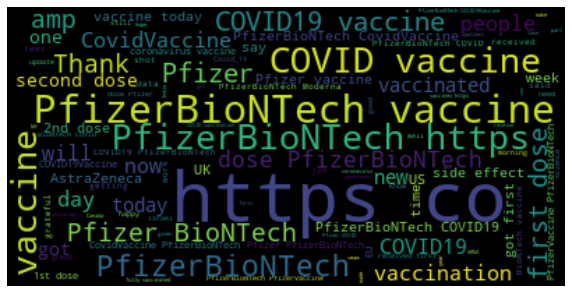

In [16]:
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

tweet_All = " ".join(review for review in data.text)


fig, ax = plt.subplots(1, 1, figsize  = (10,10))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(tweet_All)

# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')

ax.axis('off')

plt.savefig('vaccine1.png')

## Membuang tanda baca dan mengecilkan huruf besar

Kalo salah, run dibawah

In [17]:
data['text_tokenized'] = data['text_tokenized']
#data['text_to_tokenized'] = data['text_tokenized']
data.head(5)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,text_tokenized,hashtags,source,retweets,favorites,is_retweet,sentiment,positive,negative,neutral,compound
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,Positive,0.213,0.00,0.787,0.4019
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,Negative,0.113,0.13,0.756,-0.1027
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,Positive,0.133,0.00,0.867,0.2500
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...","Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,Neutral,0.000,0.00,1.000,0.0000
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,Neutral,0.000,0.00,1.000,0.0000


In [18]:
def clean_text(text):
    
    text = str(text).lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    return text
data['text_tokenized'] = data['text_tokenized'].apply(lambda x:clean_text(x))

In [19]:
data['text_tokenized']

0       same folks said daikon paste could treat a cyt...
1       while the world has been on the wrong side of ...
2       coronavirus sputnikv astrazeneca pfizerbiontec...
3       facts are immutable senator even when youre no...
4       explain to me again why we need a vaccine bori...
                              ...                        
9123    thrilled so relieved and very thankful to get ...
9124    to those vaccinated with the covid vaccine ple...
9125    israël data reportedly shows drop in efficacy ...
9126    ineffective experimental gene therapy ⬇️⬇️ pfi...
9127    crossvaccinated nordic residents can not enter...
Name: text_tokenized, Length: 9128, dtype: object

##Stemming dan Lemmatisasi
- df menunjukan keseluruhan pemrosesan text.
- Dari df, kita bisa menentukan metode stemming (Porter atau Snowballing) atau lemmatisasi atau keduanya yang cocok untuk data kita.

In [20]:
df=pd.DataFrame()
df['text_tokenized']=data['text_tokenized']
def tokenization(text):
    text = re.split('\W+', text)
    return text

df['tokenized'] = df['text_tokenized'].apply(lambda x: tokenization(x.lower()))
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
df['No_stopwords'] = df['tokenized'].apply(lambda x: remove_stopwords(x))

ps = nltk.PorterStemmer()

def stemming1(text):
    text = [ps.stem(word) for word in text]
    return text

df['stemmed_porter'] = df['No_stopwords'].apply(lambda x: stemming1(x))

from nltk.stem.snowball import SnowballStemmer
s_stemmer = SnowballStemmer(language='english')
def stemming2(text):
    text = [s_stemmer.stem(word) for word in text]
    return text
df['stemmed_snowball'] = df['No_stopwords'].apply(lambda x: stemming2(x))

wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df['lemmatized'] = df['No_stopwords'].apply(lambda x: lemmatizer(x))
df.head()

,text_tokenized,tokenized,No_stopwords,stemmed_porter,stemmed_snowball,lemmatized
0,same folks said daikon paste could treat a cyt...,"[same, folks, said, daikon, paste, could, trea...","[folks, said, daikon, paste, could, treat, cyt...","[folk, said, daikon, past, could, treat, cytok...","[folk, said, daikon, past, could, treat, cytok...","[folk, said, daikon, paste, could, treat, cyto..."
1,while the world has been on the wrong side of ...,"[while, the, world, has, been, on, the, wrong,...","[world, wrong, side, history, year, hopefully,...","[world, wrong, side, histori, year, hope, bigg...","[world, wrong, side, histori, year, hope, bigg...","[world, wrong, side, history, year, hopefully,..."
2,coronavirus sputnikv astrazeneca pfizerbiontec...,"[coronavirus, sputnikv, astrazeneca, pfizerbio...","[coronavirus, sputnikv, astrazeneca, pfizerbio...","[coronaviru, sputnikv, astrazeneca, pfizerbion...","[coronavirus, sputnikv, astrazeneca, pfizerbio...","[coronavirus, sputnikv, astrazeneca, pfizerbio..."
3,facts are immutable senator even when youre no...,"[facts, are, immutable, senator, even, when, y...","[facts, immutable, senator, even, youre, ethic...","[fact, immut, senat, even, your, ethic, sturdi...","[fact, immut, senat, even, your, ethic, sturdi...","[fact, immutable, senator, even, youre, ethica..."
4,explain to me again why we need a vaccine bori...,"[explain, to, me, again, why, we, need, a, vac...","[explain, need, vaccine, borisjohnson, matthan...","[explain, need, vaccin, borisjohnson, matthanc...","[explain, need, vaccin, borisjohnson, matthanc...","[explain, need, vaccine, borisjohnson, matthan..."


Kedua metode stemming menghasilkan kalimat yang  lebih pendek dari yang seharusnya, namun, lemmatisasi lebih menjaga struktur katanya lebih baik daripada stemming. 

In [21]:
data['text_tokenized']=df['lemmatized']
data.head(1)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,text_tokenized,hashtags,source,retweets,favorites,is_retweet,sentiment,positive,negative,neutral,compound
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,"[folk, said, daikon, paste, could, treat, cyto...",['PfizerBioNTech'],Twitter for Android,0,0,False,Positive,0.213,0.0,0.787,0.4019


# Exploratory Data Analysis

## Sentiment Counts

In [22]:
temp = data.groupby('sentiment').count()['text_tokenized'].reset_index().sort_values(by='text_tokenized',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text_tokenized
2,Positive,3938
1,Neutral,3661
0,Negative,1529


## Funnel Chart untuk Visualisasi Sentiment Distribution

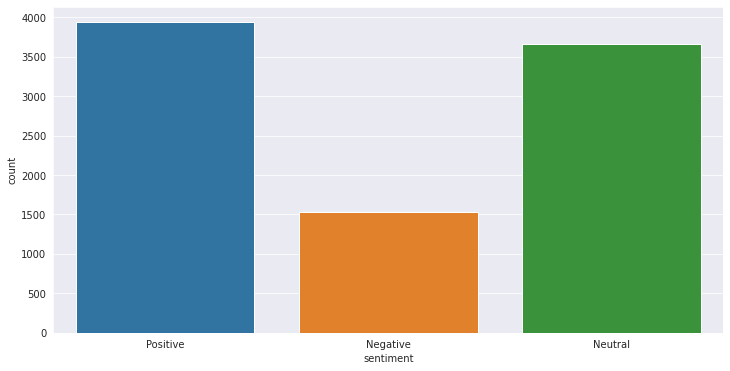

In [23]:

plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=data)
fig = go.Figure(
                go.Funnelarea(
                              text =temp.sentiment,
                              values = temp.text_tokenized,
                              title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
                              )
                )
fig.show()

## Ranking Sentiment berdasarkan tiga metrik

1. The first metric is the specific sentiment's count throughout the tweet data.neutral tweets are at top here.

2. The second metric is the sum of favorites on a particular sentiment's tweet.it can be seen that the positive tweets get the highest favorites even though neutral tweets have the highest count.atleast people want to be positive when it's a vaccine being talked about.

3. The third metric is the sum of retweets on a particular sentiment's tweet.it can be seen that the neutral tweets get the highest retweets.

Negative tweets is at the last position in all the three metrics



In [24]:
genre_difference_metric = [data['sentiment'].value_counts().index,data.groupby(['sentiment']).sum()['favorites'].sort_values(ascending=False).index,data.groupby(['sentiment']).sum()['retweets'].sort_values(ascending=False).index]

#Dataframe to be used for plotting.
genre_evolution_df = pd.DataFrame(columns=['genre', 'rank_type', 'rank'])

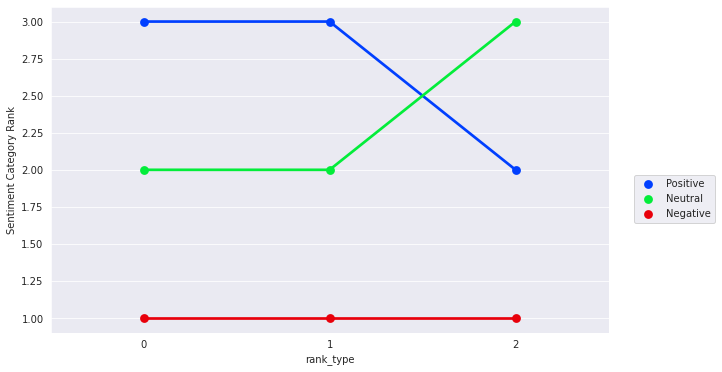

In [25]:

genre_difference_metric = [data['sentiment'].value_counts().index,data.groupby(['sentiment']).sum()['favorites'].sort_values(ascending=False).index,data.groupby(['sentiment']).sum()['retweets'].sort_values(ascending=False).index]

#Dataframe to be used for plotting.
genre_evolution_df = pd.DataFrame(columns=['genre', 'rank_type', 'rank'])

#Populate the dataframe
for metric in range(3):
    for genre in range(len(genre_difference_metric[metric])):
        genre_evolution_df = genre_evolution_df.append({'genre':genre_difference_metric[metric][genre], 'rank_type': metric, 'rank':genre},
                                   ignore_index=True)
plt.style.use('seaborn-bright')       
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

    

ax.set_xlim([-2,4])
xs = [0.0, 1.0, 2.0]
x_labels = ['sentiment count', 'sum of favorites', 'sum of retweets']
plt.xticks(range(len(xs)), x_labels)
#plt.xticks(xs, x_labels)
ax.set_xlabel('Describe of rank type')
sns.pointplot(x=genre_evolution_df.rank_type,
              y=3-genre_evolution_df['rank'], 
             hue=genre_evolution_df.genre)
ys = range(1,5)
y_labels = ['3rd', '2nd', '1st']
ax.set_ylabel('Sentiment Category Rank')

plt.legend(bbox_to_anchor=(0.7, 0., 0.5, 0.5),loc='best',ncol=1)

plt.savefig('vaccine3.png')

plt.show();  

## Account: Verified and Non-Verified Distribution

No handles with labels found to put in legend.


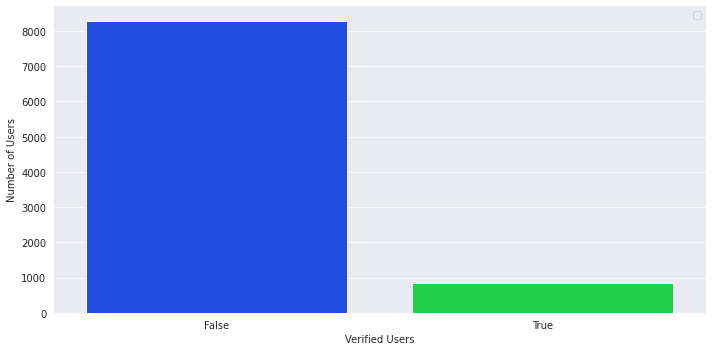

<Figure size 432x288 with 0 Axes>

In [26]:
sns.catplot(data=data, x='user_verified', kind= 'count',height=5,aspect=2)
plt.xlabel("Verified Users")
plt.ylabel("Number of Users")
plt.legend()
plt.show()
plt.savefig('vaccine4.png')

## Distribution of the Favorites Recieved based on Tweet Sentiment and Whether the account is Verified or Not Verified

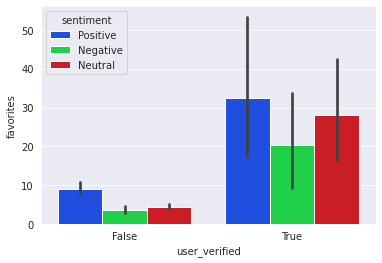

In [27]:
sns.barplot(x="user_verified", y="favorites", hue="sentiment", data=data)
plt.savefig('vaccine5.png')

## Distribution of the Retweets based on Tweet Sentiment and Whether the Account is Verified or Not Verified

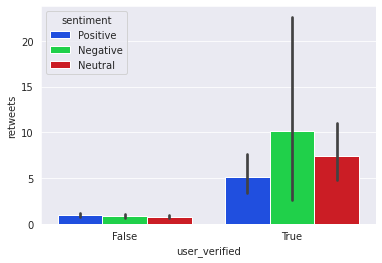

In [28]:
sns.barplot(x="user_verified", y="retweets", hue="sentiment", data=data)
plt.savefig('vaccine6.png')

## The Top 30 Most Frequently occuring Words in the Tweet Text Data

In [29]:
data.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'text_tokenized', 'hashtags', 'source', 'retweets',
       'favorites', 'is_retweet', 'sentiment', 'positive', 'negative',
       'neutral', 'compound'],
      dtype='object')

In [30]:
# !pip install plotly==4.8.2
!pip install --upgrade plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.2 MB 4.5 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [88]:
data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,text_tokenized,hashtags,source,retweets,favorites,is_retweet,sentiment,positive,negative,neutral,compound
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,"[folk, said, daikon, paste, could, treat, cyto...",['PfizerBioNTech'],Twitter for Android,0,0,False,Positive,0.213,0.00,0.787,0.4019
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,"[world, wrong, side, history, year, hopefully,...",[],Twitter Web App,1,1,False,Negative,0.113,0.13,0.756,-0.1027
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"[coronavirus, sputnikv, astrazeneca, pfizerbio...","['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,Positive,0.133,0.00,0.867,0.2500
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...","[fact, immutable, senator, even, youre, ethica...",[],Twitter Web App,446,2129,False,Neutral,0.000,0.00,1.000,0.0000
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"[explain, need, vaccine, borisjohnson, matthan...","['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,Neutral,0.000,0.00,1.000,0.0000


In [31]:
all_words=[]
for i in range(len(data['text_tokenized'])):
    a=data['text_tokenized'][i]
    for i in a:
        all_words.append(i)
all_words=pd.Series(np.array(all_words))

common_words=all_words.value_counts()[:30].rename_axis('Common Words').reset_index(name='count')
common_words.head()
# fig = px.treemap(common_words, path=['Common Words'], values='count',title='30 Most Common Words In Tweets')
# fig.show()


,Common Words,count
0,,9213
1,pfizerbiontech,5243
2,vaccine,4413
3,covid,1331
4,pfizer,1270


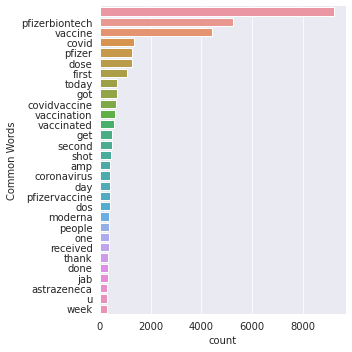

In [32]:
sns.catplot(x="count", y="Common Words",  data=common_words, kind='bar')
#plt.savefig('vaccine7.png')

## The Top 30 Most Frequently used Hashtags in the Tweet Text Data

In [33]:
data['hashtags']=data['hashtags'].fillna('[]')
all_hashtags=[]
for i in range(len(data['hashtags'])):
    a=data['hashtags'][i].strip('][').split(', ') 
    for i in a:
        all_hashtags.append(i)
all_hashtags=['No Hashtag' if x=='' else x for x in all_hashtags]       

all_hashtags=pd.Series(np.array(all_hashtags))
print('There are {} instances of tweets in which No Hashtags were used'.format(all_hashtags.value_counts()[1]))

common_hashtags=all_hashtags.value_counts().drop(labels='No Hashtag')[:30].rename_axis('Common Hashtags').reset_index(name='count')
common_hashtags.head()

# fig = px.treemap(common_hashtags, path=['Common Hashtags'], values='count',title='30 Most Common Hashtags')
# fig.show()

There are 2151 instances of tweets in which No Hashtags were used


,Common Hashtags,count
0,'PfizerBioNTech',3695
1,'COVID19',996
2,'PfizerBiontech',954
3,'vaccine',778
4,'CovidVaccine',563


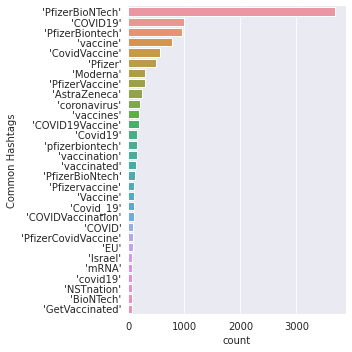

In [34]:
sns.catplot(x="count", y="Common Hashtags",  data=common_hashtags, kind='bar')
plt.savefig('vaccine8.png')

##Sentiment Wise Analysis of Hashtag and Words

In [35]:
Positive_tweet = data[data['sentiment']=='Positive'].reset_index()
Negative_tweet = data[data['sentiment']=='Negative'].reset_index()
Neutral_tweet  = data[data['sentiment']=='Neutral'] .reset_index()

### Positive Tweets

In [36]:
top_positive_tweets = pd.DataFrame(data = {'Top Positive Tweets' : data[data['sentiment']=='Positive']['text'], 'retweets' : data['retweets']})
top_positive_tweets.sort_values(by='retweets',ascending=False).dropna().head(5)

,Top Positive Tweets,retweets
5364,Please Retweet!\n\n⭐️Comparison of the 6 top C...,324
183,Welcoming the 1st #COVID19vaccines to 🇨🇦 tonig...,284
6268,UPDATED 2/26/21:\n\n⭐️Comparison of the 6 top ...,236
1125,LETHAL INJECTION 💉 🤣\n\n#PfizerBioNTech #pfize...,104
4069,Kid you not. \nI vaccinated this 99 year old a...,85


#### Common Positive Words

In [37]:
all_positive_words=[]
all_positive_hashtags=[]
for i in range(len(Positive_tweet['text_tokenized'])):
    a=Positive_tweet['text_tokenized'][i]
    b=Positive_tweet['hashtags'][i].strip('][').split(', ')
    for i in a:
        all_positive_words.append(i)
    for i in b:
        all_positive_hashtags.append(i)
all_positive_words=pd.Series(np.array(all_positive_words))
all_positive_hashtags=pd.Series(np.array(all_positive_hashtags))
common_words=all_positive_words.value_counts().drop(labels='')[:70].rename_axis('Common Positive Words').reset_index(name='count')
common_words.head()
# fig = px.treemap(common_words, path=['Common Positive Words'], values='count',title='70 Most Common Words In Positive Tweets')
# fig.show()

,Common Positive Words,count
0,pfizerbiontech,2202
1,vaccine,1851
2,dose,598
3,covid,566
4,pfizer,502


#### Common Positive Hashtags

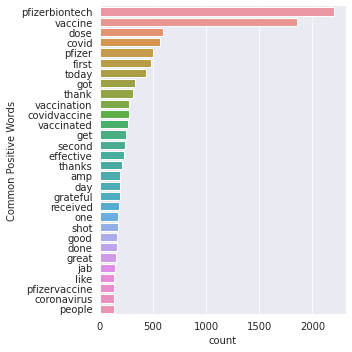

In [38]:
sns.catplot(x="count", y="Common Positive Words",  data=common_words.head(30), kind='bar')
plt.savefig('vaccine9.png')

In [39]:
common_hashtags=all_positive_hashtags.value_counts()[:70].drop(labels='').rename_axis('Common Positive Hashtags').reset_index(name='count')
# fig = px.treemap(common_hashtags, path=['Common Positive Hashtags'], values='count',title='70 Most Common Hashtags In Positive Tweets')
# fig.show()
common_hashtags.head()

,Common Positive Hashtags,count
0,'PfizerBioNTech',1530
1,'PfizerBiontech',430
2,'COVID19',379
3,'vaccine',304
4,'CovidVaccine',241


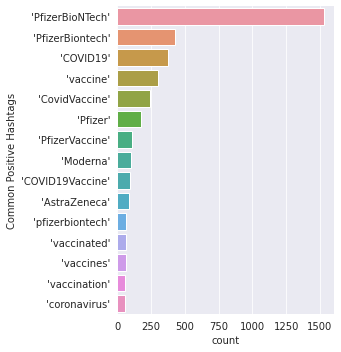

In [40]:
sns.catplot(x="count", y="Common Positive Hashtags",  data=common_hashtags.head(15), kind='bar')
plt.savefig('vaccine10.png')

### Negative Tweets

In [41]:
top_negative_tweets = pd.DataFrame(data = {'Top Negative Tweets' : data[data['sentiment']=='Negative']['text'], 'retweets' : data['retweets']})
top_negative_tweets.sort_values(by='retweets',ascending=False).dropna().head(5)

,Top Negative Tweets,retweets
3440,55 people in the US have died after receiving ...,678
922,The @US_FDA is investigating around 5 allergic...,176
3867,Display board in Ireland says it all. It’s a m...,112
8158,@pfizer This user account says “Your company'...,70
1393,#BREAKING: Dubai Emergency Crisis and Disaster...,62


#### Common Negative Words

In [42]:
all_negative_words=[]
all_negative_hashtags=[]
for i in range(len(Negative_tweet['text_tokenized'])):
    a=Negative_tweet['text_tokenized'][i]
    b=Negative_tweet['hashtags'][i].strip('][').split(', ')
    for i in a:
        all_negative_words.append(i)
    for i in b:
        all_negative_hashtags.append(i)
all_negative_words=pd.Series(np.array(all_negative_words))
all_negative_hashtags=pd.Series(np.array(all_negative_hashtags))
common_words=all_negative_words.value_counts().drop(labels='')[:70].rename_axis('Common Negative Words').reset_index(name='count')
# fig = px.treemap(common_words, path=['Common Negative Words'], values='count',title='70 Most Common Words In Negative Tweets')
# fig.show()
common_words.head()

,Common Negative Words,count
0,pfizerbiontech,731
1,vaccine,719
2,pfizer,250
3,covid,208
4,dose,141


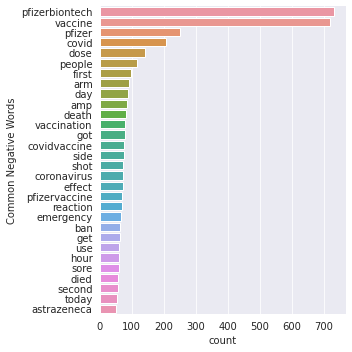

In [43]:
sns.catplot(x="count", y="Common Negative Words",  data=common_words.head(30), kind='bar')
plt.savefig('vaccine11.png')

#### Common Negative Hashtags

In [44]:
common_hashtags=all_negative_hashtags.value_counts()[:70].drop(labels='').rename_axis('Common Negative Hashtags').reset_index(name='count')
# fig = px.treemap(common_hashtags, path=['Common Negative Hashtags'], values='count',title='70 Most Common Hashtags In Negative Tweets')
# fig.show()
common_hashtags.head()

,Common Negative Hashtags,count
0,'PfizerBioNTech',545
1,'COVID19',156
2,'vaccine',117
3,'PfizerBiontech',99
4,'Pfizer',89


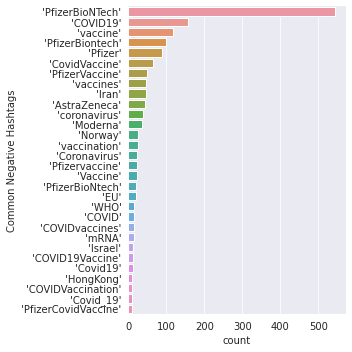

In [45]:
sns.catplot(x="count", y="Common Negative Hashtags",  data=common_hashtags.head(30), kind='bar')
plt.savefig('vaccine12.png')

### Neutral Tweets

In [46]:
top_neutral_tweets = pd.DataFrame(data = {'Top Neutral Tweets' : data[data['sentiment']=='Neutral']['text'], 'retweets' : data['retweets']})
top_neutral_tweets.sort_values(by='retweets',ascending=False).dropna().head(5)

,Top Neutral Tweets,retweets
3,"Facts are immutable, Senator, even when you're...",446
4213,What do you need to know about #PfizerBioNTech...,389
3004,🇨🇦 has received &amp; distributed over half a ...,230
2826,A Palace source said the vaccines were adminis...,199
6092,WHO Strategic Advisory Group of Experts (SAGE)...,117


#### Common Neutral Words

In [47]:
all_neutral_words=[]
all_neutral_hashtags=[]
for i in range(len(Neutral_tweet['text_tokenized'])):
    a=Neutral_tweet['text_tokenized'][i]
    b=Neutral_tweet['hashtags'][i].strip('][').split(', ')
    for i in a:
        all_neutral_words.append(i)
    for i in b:
        all_neutral_hashtags.append(i)
all_neutral_words=pd.Series(np.array(all_neutral_words))
all_neutral_hashtags=pd.Series(np.array(all_neutral_hashtags))
common_words=all_neutral_words.value_counts().drop(labels='')[:70].rename_axis('Common Neutral Words').reset_index(name='count')
# fig = px.treemap(common_words, path=['Common Neutral Words'], values='count',title='70 Most Common Words In Neutral Tweets')
# fig.show()
plt.savefig('vaccine13.png')
common_words.head()

,Common Neutral Words,count
0,pfizerbiontech,2310
1,vaccine,1843
2,covid,557
3,pfizer,518
4,dose,513


<Figure size 432x288 with 0 Axes>

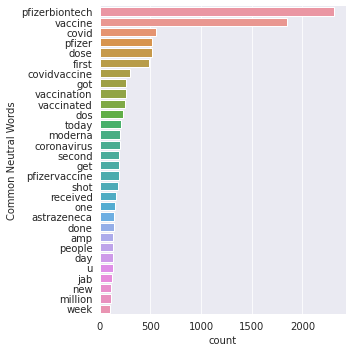

In [48]:
sns.catplot(x="count", y="Common Neutral Words",  data=common_words.head(30), kind='bar')
plt.savefig('vaccine14.png')

#### Common Neutral Hashtags

In [49]:
common_hashtags=all_neutral_hashtags.value_counts()[:70].drop(labels='').rename_axis('Common Neutral Hashtags').reset_index(name='count')
# fig = px.treemap(common_hashtags, path=['Common Neutral Hashtags'], values='count',title='70 Most Common Hashtags In Neutral Tweets')
# fig.show()
common_hashtags.head()

,Common Neutral Hashtags,count
0,'PfizerBioNTech',1620
1,'COVID19',461
2,'PfizerBiontech',425
3,'vaccine',357
4,'CovidVaccine',257


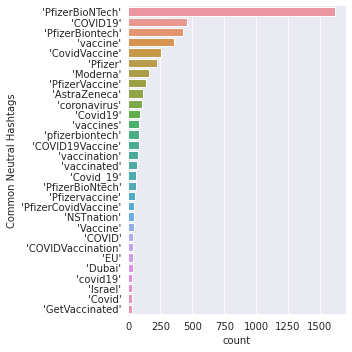

In [50]:
sns.catplot(x="count", y="Common Neutral Hashtags",  data=common_hashtags.head(30), kind='bar')
plt.savefig('vaccine15.png')

It can be seen that:
- 'PfizerBioNTech',
- 'COVID19',
- 'vaccine',
- etc

Are common in all the sentiments and are not giving a clear distinction in the words used exclusively for a particular sentiment. So,the following plots show the distribution of words that are unique to each sentiment.

### Top 30 Unique Words

#### Common Negative Words

In [89]:
common=set(all_positive_words).intersection(set(all_negative_words)).intersection(set(all_neutral_words))
common_list=list(common)

common_words=all_negative_words.value_counts().drop(labels=common_list)[:30].rename_axis('Common Negative Words').reset_index(name='count')
# fig = px.treemap(common_words, path=['Common Negative Words'], values='count',title='Top 30 Unique Words In Negative Tweets')
# fig.show()
common_words.head()

all_negative_words=[]
all_negative_hashtags=[]
for i in range(len(Negative_tweet['text_tokenized'])):
    a=Negative_tweet['text_tokenized'][i]
    b=Negative_tweet['hashtags'][i].strip('][').split(', ')
    for i in a:
        all_negative_words.append(i)
    for i in b:
        all_negative_hashtags.append(i)
all_negative_words=pd.Series(np.array(all_negative_words))
all_negative_hashtags=pd.Series(np.array(all_negative_hashtags))
common_words=all_negative_words.value_counts().drop(labels='')[:70].rename_axis('Common Negative Words').reset_index(name='count')
fig = px.treemap(common_words, path=['Common Negative Words'], values='count',title='70 Most Common Words In Negative Tweets')
fig.show()
common_words.head()

,Common Negative Words,count
0,pfizerbiontech,731
1,vaccine,719
2,pfizer,250
3,covid,208
4,dose,141


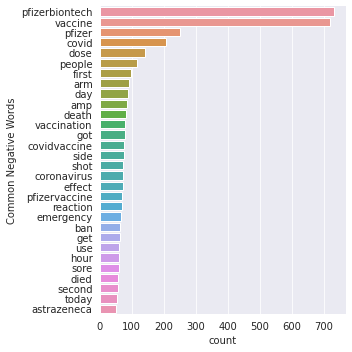

In [52]:
sns.catplot(x="count", y="Common Negative Words",  data=common_words.head(30), kind='bar')
plt.savefig('vaccine16.png')

#### Common Positive Words

In [53]:
common_words=all_positive_words.value_counts().drop(labels=common_list)[:30].rename_axis('Common Positive Words').reset_index(name='count')
# fig = px.treemap(common_words, path=['Common Positive Words'], values='count',title='Top 30 Unique Words In Positive Tweets')
# fig.show()
common_words.head()

,Common Positive Words,count
0,happy,104
1,hope,88
2,safe,85
3,safety,69
4,approval,55


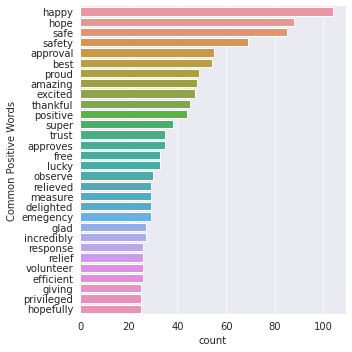

In [54]:
sns.catplot(x="count", y="Common Positive Words",  data=common_words.head(30), kind='bar')
plt.savefig('vaccine17.png')

#### Common Neutral Words

In [55]:
common_words=all_neutral_words.value_counts().drop(labels=common_list)[:30].rename_axis('Common Neutral Words').reset_index(name='count')
# fig = px.treemap(common_words, path=['Common Neutral Words'], values='count',title='Top 30 Unique Words In Neutral Tweets')
# fig.show()
common_words.head()

,Common Neutral Words,count
0,conservative,21
1,clinic,20
2,additional,17
3,beginning,14
4,updated,14


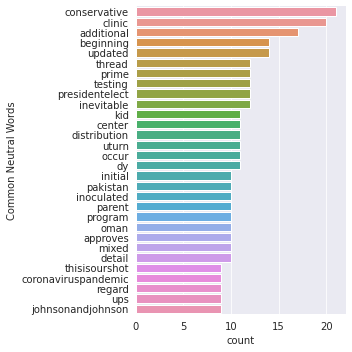

In [56]:
sns.catplot(x="count", y="Common Neutral Words",  data=common_words.head(30), kind='bar')
plt.savefig('vaccine18.png')

### Source Distribution of Tweets

In [57]:
# data_ = data['source'].value_counts().reset_index()

# trace1 = go.Bar(
#                 x = ['Twitter for Android', 'Twitter Web App', 'Twitter for iPhone',
#                     'TweetDeck', 'Buffer', 'Twitter for iPad', 'Twitter Media Studio',
#                     'ThreadReaderApp', 'Instagram', 'SocialFlow', 'Hootsuite Inc.',
#                     'LinkedIn', 'Twitter for Mac', '24liveblog', 'Publer ', 'IFTTT',
#                     'Socialbakers', 'Falcon Social Media Management ', 'Echobox',
#                     'Microsoft Power Platform', 'Nonli', 'Sendible',
#                     'Tweetbot for Mac', 'EastMojo',
#                     'Twitter Media Studio - LiveCut'], #temp_df['index'],
#                 y = data_['source'],
#                 marker = dict(color = 'rgb(250,13,92)',
#                               line  = dict(color='rgb(0,0,0)',
#                                           width=1.5)),
#                 text=data_['source'], textposition='outside')
# layout = go.Layout(
#     template= "plotly_dark",
#     title = 'SOURCE DISTRIBUTION OF TWEETS' ,
#     xaxis = dict(title = 'SOURCE'), 
#     yaxis = dict(title = 'Count'), 
#     height=650)
# # fig = go.Figure(data = [trace1], layout = layout)
# # fig.show()

In [58]:
data.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'text_tokenized', 'hashtags', 'source', 'retweets',
       'favorites', 'is_retweet', 'sentiment', 'positive', 'negative',
       'neutral', 'compound'],
      dtype='object')

In [59]:
source_tweet = pd.DataFrame(data['source'].value_counts()).reset_index()
source_tweet.columns = ['Source','Count']
source_tweet.head()

,Source,Count
0,Twitter for iPhone,3143
1,Twitter Web App,2598
2,Twitter for Android,2184
3,TweetDeck,529
4,Twitter for iPad,247


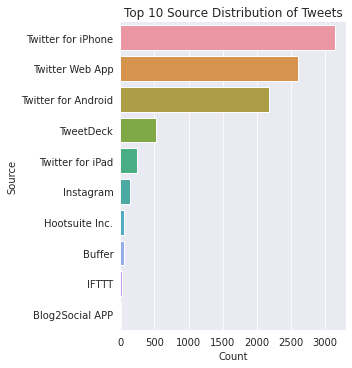

In [60]:
sns.catplot(x='Count', y='Source',  data=source_tweet.head(10), kind='bar')
plt.title("Top 10 Source Distribution of Tweets")
plt.savefig('vaccine19.png')
plt.show()

#### Source Distribution of Tweets from Verified Accounts

In [61]:
data_verified     = data[(data['user_verified']== True)].reset_index()
data_not_verified = data[(data['user_verified']== False)].reset_index()
data_verified.head(2)

,index,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,text_tokenized,hashtags,source,retweets,favorites,is_retweet,sentiment,positive,negative,neutral,compound
0,3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...","[fact, immutable, senator, even, youre, ethica...",[],Twitter Web App,446,2129,False,Neutral,0.00,0.000,1.000,0.0000
1,7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,There have not been many bright days in 2020 b...,"[many, bright, day, best, bidenharris, winning, ]","['BidenHarris', 'Election2020']",Twitter for iPhone,2,22,False,Positive,0.37,0.061,0.569,0.8933


In [62]:
verif = data[data['user_verified']==True]['source'].value_counts().reset_index()
verif.columns = ['Source', 'Count']
verif

,Source,Count
0,Twitter Web App,292
1,TweetDeck,291
2,Twitter for iPhone,155
3,Twitter for Android,21
4,Hootsuite Inc.,20
5,Buffer,16
6,Twitter for iPad,14
7,SocialFlow,7
8,Nelio Content,4
9,Twitter Media Studio - LiveCut,3


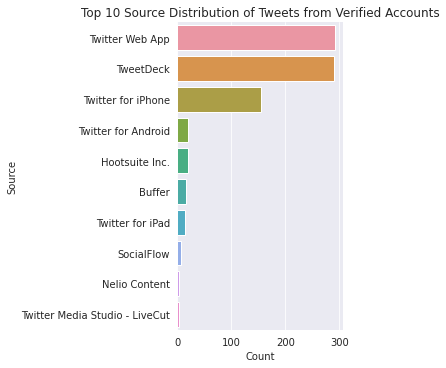

In [63]:
sns.catplot(x='Count', y='Source',  data=verif.head(10), kind='bar')
plt.title("Top 10 Source Distribution of Tweets from Verified Accounts")
plt.savefig('vaccine20.png')
plt.show()

#### Source Distribution of Tweets from Non Verified Accounts

In [64]:
noverif = data[data['user_verified']==False]['source'].value_counts().reset_index()
noverif.columns = ['Source', 'Count']
noverif

,Source,Count
0,Twitter for iPhone,2988
1,Twitter Web App,2306
2,Twitter for Android,2163
3,TweetDeck,238
4,Twitter for iPad,233
5,Instagram,139
6,Buffer,41
7,Hootsuite Inc.,37
8,IFTTT,17
9,Blog2Social APP,16


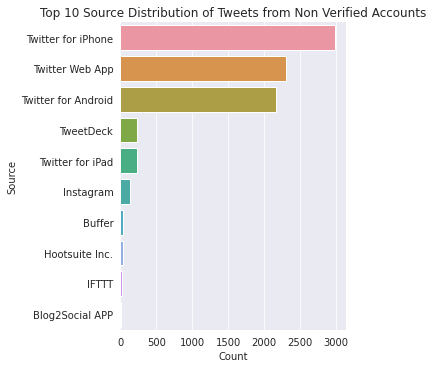

In [65]:
sns.catplot(x='Count', y='Source',  data=noverif.head(10), kind='bar')
plt.title("Top 10 Source Distribution of Tweets from Non Verified Accounts")
plt.savefig('vaccine21.png')
plt.show()

### Hashtags

#### 30 Most Common Hashtags by Verified Accounts

In [66]:
all_hashtags=[]
for i in range(len(data_verified['hashtags'])):
    a=data_verified['hashtags'][i].strip('][').split(', ') 
    for i in a:
        all_hashtags.append(i)
all_hashtags=['No Hashtag' if x=='' else x for x in all_hashtags]       

all_hashtags=pd.Series(np.array(all_hashtags))
common_hashtags=all_hashtags.value_counts()[:30].rename_axis('Common Hashtags').reset_index(name='count')
# fig = px.treemap(common_hashtags, path=['Common Hashtags'], values='count',title='30 Most Common Hashtags by VERIFIED ACCOUNTS')
# fig.show()
common_hashtags.head()

,Common Hashtags,count
0,'PfizerBioNTech',393
1,No Hashtag,144
2,'vaccine',113
3,'COVID19',109
4,'NSTnation',63


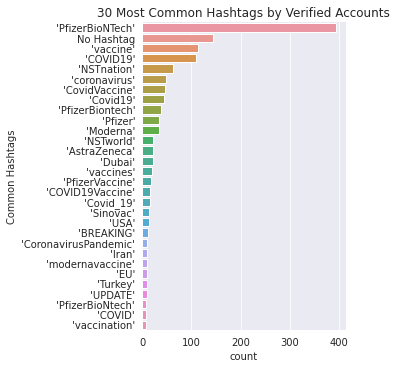

In [67]:
sns.catplot(x='count', y='Common Hashtags',  data=common_hashtags, kind='bar')
plt.title("30 Most Common Hashtags by Verified Accounts")
plt.savefig('vaccine22.png')
plt.show()

### Sentiment Wise Word Frequency

#### 30 Most Common Unique Negative Words by Verified Accounts

In [68]:


Positive_tweet = data_verified[data_verified['sentiment']=='Positive'].reset_index()
Negative_tweet = data_verified[data_verified['sentiment']=='Negative'].reset_index()
Neutral_tweet = data_verified[data_verified['sentiment']=='Neutral'].reset_index()
all_positive_words=[]

for i in range(len(Positive_tweet['text_tokenized'])):
    a=Positive_tweet['text_tokenized'][i]
    
    for i in a:
        all_positive_words.append(i)
    
all_positive_words=pd.Series(np.array(all_positive_words))
all_neutral_words=[]

for i in range(len(Neutral_tweet['text_tokenized'])):
    a=Neutral_tweet['text_tokenized'][i]
    
    for i in a:
        all_neutral_words.append(i)
    
all_neutral_words=pd.Series(np.array(all_neutral_words))
all_negative_words=[]

for i in range(len(Negative_tweet['text_tokenized'])):
    a=Negative_tweet['text_tokenized'][i]
   
    for i in a:
        all_negative_words.append(i)
    
all_negative_words=pd.Series(np.array(all_negative_words))
common=set(all_positive_words).intersection(set(all_negative_words)).intersection(set(all_neutral_words))
common_list=list(common)

common_words=all_negative_words.value_counts().drop(labels=common_list)[:30].rename_axis('Common Negative Words').reset_index(name='count')
# fig = px.treemap(common_words, path=['Common Negative Words'], values='count',title='30 Most Common Unique Negative Words by VERIFIED ACCOUNTS')
# fig.show()
common_words.head()

,Common Negative Words,count
0,toll,13
1,allergic,11
2,turkey,10
3,reach,7
4,died,6


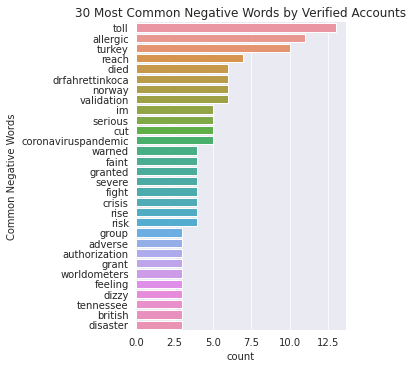

In [69]:
sns.catplot(x='count', y='Common Negative Words',  data=common_words, kind='bar')
plt.title("30 Most Common Negative Words by Verified Accounts")
plt.savefig('vaccine23.png')
plt.show()

In [70]:
common_words=all_positive_words.value_counts().drop(labels=common_list)[:30].rename_axis('Common Positive Words').reset_index(name='count')
# fig = px.treemap(common_words, path=['Common Positive Words'], values='count',title='30 Most Common Unique Positive Words by VERIFIED ACCOUNTS')
# fig.show()
common_words.head()

,Common Positive Words,count
0,effective,32
1,approved,25
2,number,12
3,like,10
4,good,10


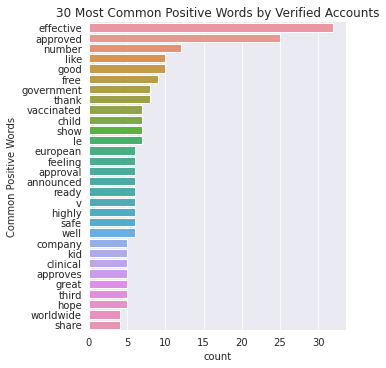

In [71]:
sns.catplot(x='count', y='Common Positive Words',  data=common_words, kind='bar')
plt.title("30 Most Common Positive Words by Verified Accounts")
plt.savefig('vaccine24.png')
plt.show()

In [72]:
common_words=all_neutral_words.value_counts().drop(labels=common_list)[:30].rename_axis('Common Neutral Words').reset_index(name='count')
# fig = px.treemap(common_words, path=['Common Neutral Words'], values='count',title='30 Most Common Unique Neutral Words by VERIFIED ACCOUNTS')
# fig.show()
common_words.head()

,Common Neutral Words,count
0,iran,19
1,vaccinated,17
2,batch,14
3,start,11
4,group,11


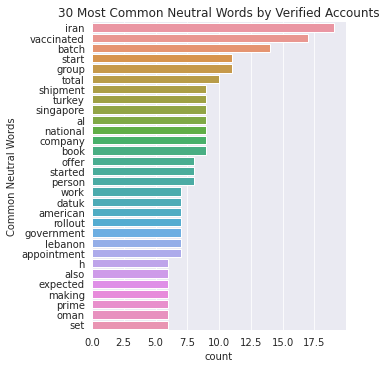

In [73]:
sns.catplot(x='count', y='Common Neutral Words',  data=common_words, kind='bar')
plt.title("30 Most Common Neutral Words by Verified Accounts")
plt.savefig('vaccine25.png')
plt.show()

### Tweet Sentiment Based Analysis of Location

#### 10 Top Unique Negative Tweets Locations

In [74]:
data['user_location'] = data['user_location'].fillna('NaN')
Positive_tweet = data[data['sentiment']=='Positive'].reset_index()
Negative_tweet = data[data['sentiment']=='Negative'].reset_index()
Neutral_tweet = data[data['sentiment']=='Neutral'].reset_index()
pos_location=Positive_tweet['user_location']
neg_location=Negative_tweet['user_location']
neu_location=Neutral_tweet['user_location']

common=set(pos_location).intersection(set(neg_location)).intersection(set(neu_location))
common_list=list(common)

common_words=neg_location.value_counts().drop(labels=common_list)[:10].rename_axis('Common Negative Locations').reset_index(name='count')
# fig = px.treemap(common_words, path=['Common Negative Locations'], values='count',title='10 Top Unique Negative Tweets Locations')
# fig.show()
common_words.head()

,Common Negative Locations,count
0,Moronto City Of #Morons Canada,6
1,,5
2,PH. US.,5
3,"Copenhagen, Denmark",4
4,"Tempe, AZ",4


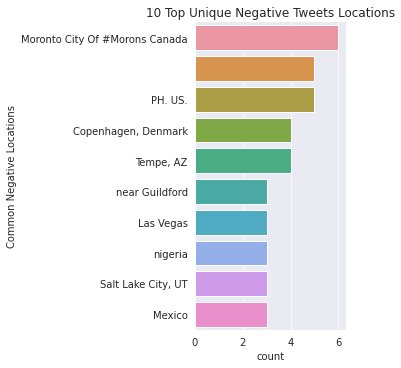

In [75]:
sns.catplot(x='count', y='Common Negative Locations',  data=common_words, kind='bar')
plt.title("10 Top Unique Negative Tweets Locations")
plt.savefig('vaccine26.png')
plt.show()

In [76]:
common_words=pos_location.value_counts().drop(labels=common_list)[:10].rename_axis('Common Positive Locations').reset_index(name='count')
# fig = px.treemap(common_words, path=['Common Positive Locations'], values='count',title='10 Top Unique Positive Tweets Locations')
# fig.show()
common_words.head()

,Common Positive Locations,count
0,Petaling Jaya,28
1,"Birmingham, England",11
2,Ragbag Of Reviews And Insights,9
3,"Manchester, England",8
4,"Liverpool, England",8


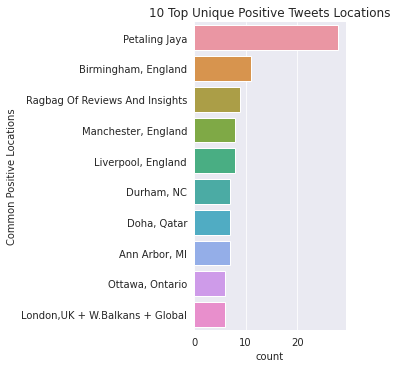

In [77]:
sns.catplot(x='count', y='Common Positive Locations',  data=common_words, kind='bar')
plt.title("10 Top Unique Positive Tweets Locations")
plt.savefig('vaccine27.png')
plt.show()

In [78]:
common_words=neu_location.value_counts().drop(labels=common_list)[:10].rename_axis('Common Neutral Locations').reset_index(name='count')
# fig = px.treemap(common_words, path=['Common Neutral Locations'], values='count',title='10 Top Unique Neutral Tweets Locations')
# fig.show()
common_words.head()

,Common Neutral Locations,count
0,Ragbag Of Reviews And Insights,40
1,Los Angeles,13
2,Tweets on #Asia & USA,10
3,"Doha, Qatar",10
4,World Wide Web,9


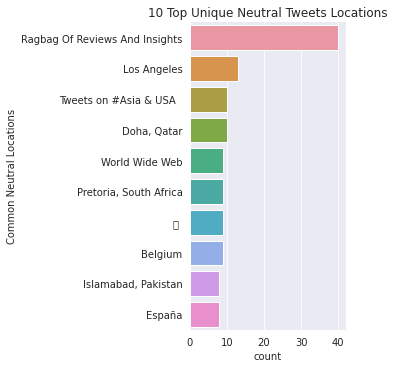

In [79]:
sns.catplot(x='count', y='Common Neutral Locations',  data=common_words, kind='bar')
plt.title("10 Top Unique Neutral Tweets Locations")
plt.show()

### **Accounts with Highest Followers** Analysis based on the Tweet Sentiment

In [80]:
from matplotlib import rcParams


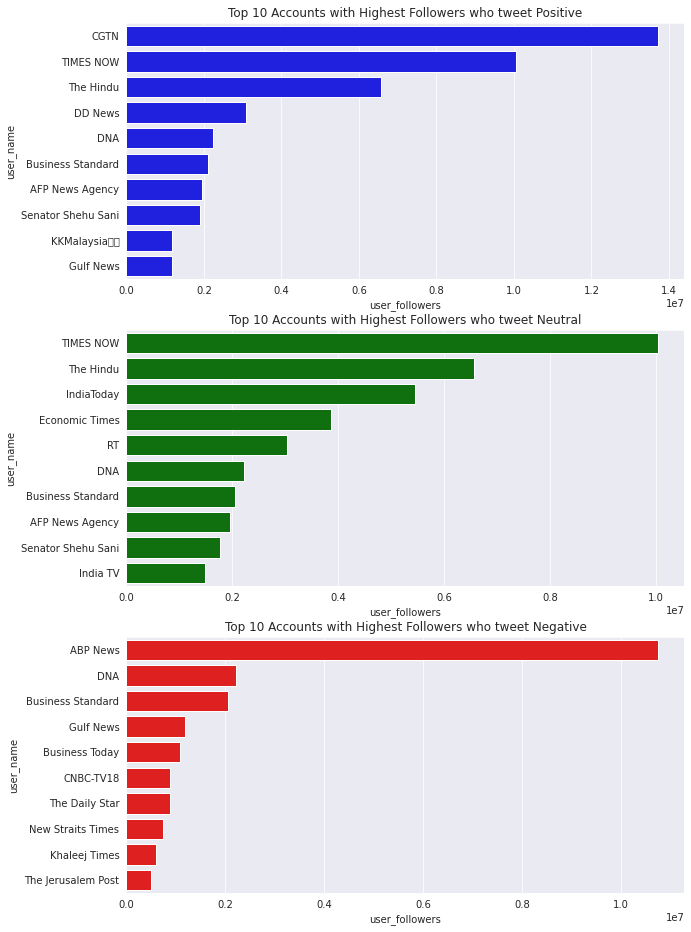

In [81]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10, 16))
sns.barplot(x="user_followers", y="user_name", orient="h", ax=ax1, palette=["b"],
           data=data[(data.sentiment== "Positive")]\
           .drop_duplicates(subset=["user_name"])\
           .sort_values(by=["user_followers"], ascending=False)[["user_name", "user_followers"]][:10])
ax1.set_title('Top 10 Accounts with Highest Followers who tweet Positive')
sns.barplot(x="user_followers", y="user_name", orient="h", ax=ax2, palette=["g"],
           data=data[(data.sentiment == "Neutral")]
           .drop_duplicates(subset=["user_name"])\
           .sort_values(by=["user_followers"], ascending=False)[["user_name", "user_followers"]][:10])
ax2.set_title('Top 10 Accounts with Highest Followers who tweet Neutral')
sns.barplot(x="user_followers", y="user_name", orient="h", ax=ax3, palette=["r"],
           data=data[(data.sentiment == "Negative")]
           .drop_duplicates(subset=["user_name"])\
           .sort_values(by=["user_followers"], ascending=False)[["user_name", "user_followers"]][:10])
ax3.set_title('Top 10 Accounts with Highest Followers who tweet Negative')

plt.savefig('vaccine29.png')

fig.show()

### Time Based Analysis of Tweet Sentiment:
- A sudden fall in the positive tweets can be seen around 22-25 Dec.
- A sudden spike in negative tweets can be seen around 30 Dec 2020.

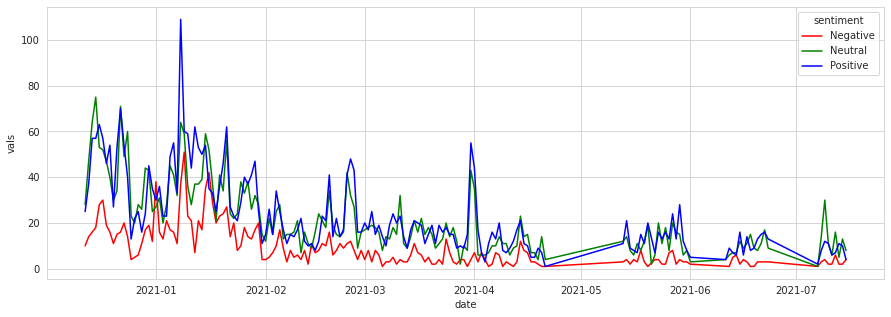

In [82]:
plt.figure(figsize=(15,5))
data["date"] = pd.to_datetime(data.date) 
timeline = data.resample('D', on='date')["sentiment"].value_counts().unstack(1)

timeline.reset_index(inplace=True)

timeline = timeline.melt("date", var_name='sentiment',  value_name='vals')

plt.savefig('vaccine30.png')

sns.set_style("whitegrid")
sns.lineplot(x="date", y="vals", hue="sentiment", data=timeline, palette=["r", "g","b"])


# Data Preparation

In [83]:
#data.drop_column('text_encoded')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9128 entries, 0 to 9127
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                9128 non-null   int64         
 1   user_name         9128 non-null   object        
 2   user_location     9128 non-null   object        
 3   user_description  8557 non-null   object        
 4   user_created      9128 non-null   object        
 5   user_followers    9128 non-null   int64         
 6   user_friends      9128 non-null   int64         
 7   user_favourites   9128 non-null   int64         
 8   user_verified     9128 non-null   bool          
 9   date              9128 non-null   datetime64[ns]
 10  text              9128 non-null   object        
 11  text_tokenized    9128 non-null   object        
 12  hashtags          9128 non-null   object        
 13  source            9127 non-null   object        
 14  retweets          9128 n

## Prepare X

In [84]:
# Tentukan jumlah max_features (jumlah kata yang ingin digunakan pada setiap kalimat)
max_features = 500 #(let say batasin 100 kata, kbnyakan apa gk ya..? bukan user tweeter)
                #ni masih g ngerti, kata unik dari sluruh kata yg dimiliki, apa kata dari tiap tweet itu doang..?
# Buat object Tokenizer() dari keras, gunakan parameter num_words untuk membatasi kata yang ingin ditokenisasi pada tiap kalimat
# dan parameter split untuk menentukan pembatas tiap kata, (' ') = spasi
tokenizer = Tokenizer(num_words=max_features, split=' ')

# Lakukan tokenisasi pada setiap kalimat dengan tokenizer yang telah dibuat
tokenizer.fit_on_texts(data['text'].values)

# Ubah token menjadi sequence/angka-angka
X = tokenizer.texts_to_sequences(data['text'].values)
#Pasti jumlah kata utk tiap tweet beda beda doong ye kaan. #Lakukan padding,
# jika jumlah kata dalam kalimat tidak sebanyak max_features maka diisi dengan angka (0)
X = pad_sequences(X)
X

array([[0, 0, 0, ..., 3, 2, 1],
       [0, 0, 0, ..., 3, 2, 1],
       [0, 0, 0, ..., 3, 2, 1],
       ...,
       [0, 0, 0, ..., 3, 2, 1],
       [0, 0, 0, ..., 3, 2, 1],
       [0, 0, 0, ..., 3, 2, 1]], dtype=int32)

## Prepare Y

In [85]:
#U knowlah what its mean hehe
y = data['sentiment']
def ConvertToLabel(nilai):
    if nilai=='Positive':
        return 2
    if nilai=='Neutral':
        return 1
    if nilai=='Negative':
        return 0
y = y.apply(ConvertToLabel)
y.value_counts()

2    3938
1    3661
0    1529
Name: sentiment, dtype: int64

## Train-Test Split

In [86]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X,y, test_size = 0.20, random_state = 1)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(7302, 28) (7302,)
(1826, 28) (1826,)


## Random Forest

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = RandomForestClassifier()
fitting = model.fit(X_train, Y_train)
Y_pred = model.predict(X_val)

print(confusion_matrix(Y_val,Y_pred))
print(classification_report(Y_val,Y_pred))
print(accuracy_score(Y_val, Y_pred))

[[ 25  84 189]
 [  8 390 344]
 [  5 228 553]]
              precision    recall  f1-score   support

           0       0.66      0.08      0.15       298
           1       0.56      0.53      0.54       742
           2       0.51      0.70      0.59       786

    accuracy                           0.53      1826
   macro avg       0.57      0.44      0.43      1826
weighted avg       0.55      0.53      0.50      1826

0.5301204819277109


# End